In [1]:
# Calculate relative abundances of MAGs in Chloroheliales enrichment cultures
# Jackson M. Tsuji, ILTS, Hokudai, 2023

In [2]:
import pandas as pd
from plotnine import *

In [4]:
# Variables
read_counts_long_filepath = 'input/read_counts_long.tsv'
read_counts_short_filepath = 'input/read_counts_short.tsv'
coverage_long_filepath = 'input/coverage_long.tsv'
coverage_short_filepath = 'input/coverage_short.tsv'
genome_naming_filepath = 'input/genome_contig_names.tsv'
gtdb_and_checkm_info_filepath = 'input/GTDB_and_checkM_stats_vs2_corr.tsv'
output_table_filepath = 'output/MAG_rel_abundances.tsv'
output_plot_filepath = 'output/MAG_rel_abundances.pdf'

metagenome_order = ['L227-5C_S00', 'L227-S17_S01', 'L227-S17_S15', 'L227-S17_S15c_long', 'L227-S17_S19', 'L227-S17_S19_long']

In [5]:
# Open and combine read counts data
read_counts_short = pd.read_csv(read_counts_short_filepath, sep='\t')
read_counts_short['Total reads'] = read_counts_short['Reads_pe'].multiply(2)
read_counts_short = read_counts_short[['Sample', 'Step', 'Total reads']]

read_counts_long = pd.read_csv(read_counts_long_filepath, sep='\t')\
  .rename(columns={'Reads_se':'Total reads'})

read_counts = pd.concat([read_counts_short, read_counts_long])
read_counts = read_counts[read_counts['Step'] == 'QC']\
  .drop(columns='Step')\
  .set_index('Sample')

read_counts

,Total reads
Sample,
L227-S17_S01,9874576.0
L227-S17_S15,16295694.0
L227-5C_S00,13566008.0
L227-S17_S19,6635828.0
L227-S17_S15c_long,75646.0
L227-S17_S19_long,131256.0


In [6]:
# Open and combine coverage info
coverage_short = pd.read_csv(coverage_short_filepath, sep='\t')
coverage_long = pd.read_csv(coverage_long_filepath, sep='\t')

coverage = pd.concat([coverage_short, coverage_long])[['sample','contig','numreads']]\
  .rename(columns={'sample':'Sample'})

coverage.head()

,Sample,contig,numreads
0,L227-5C_S00,JACAAW010000001.1,13135
1,L227-5C_S00,JACAAW010000010.1,6574
2,L227-5C_S00,JACAAW010000100.1,1576
3,L227-5C_S00,JACAAW010000101.1,1949
4,L227-5C_S00,JACAAW010000102.1,1943


In [7]:
# Map on genome names
genome_naming = pd.read_csv(genome_naming_filepath, sep='\t')

coverage_merged = coverage.merge(genome_naming, on='contig', how='left', validate='m:1')

coverage_merged.head()

,Sample,contig,numreads,genome
0,L227-5C_S00,JACAAW010000001.1,13135,Cfx2-01
1,L227-5C_S00,JACAAW010000010.1,6574,Cfx2-01
2,L227-5C_S00,JACAAW010000100.1,1576,Cfx2-01
3,L227-5C_S00,JACAAW010000101.1,1949,Cfx2-01
4,L227-5C_S00,JACAAW010000102.1,1943,Cfx2-01


In [8]:
# Load GTDB and CheckM info
gtdb_and_checkm_info = pd.read_csv(gtdb_and_checkm_info_filepath, sep='\t')
gtdb_and_checkm_info.head()

,genome,Domain,Phylum,Class,Order,Family,Genus,Species,Completeness,Contamination,Strain_heterogeneity
0,L227-G1,Bacteria,Acidobacteriota,Holophagae,Holophagales,Holophagaceae,Geothrix,Unresolved_Geothrix,NaN,NaN,NaN
1,Cfx3-06,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,BBW3,UBA8529,Unresolved_UBA8529,98.10,2.33,0.00
2,Cfx3-09,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,FEN-979,Unresolved_FEN-979,Unresolved_FEN-979,97.31,2.69,0.00
3,Cfx3-02,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,UBA4417,Unresolved_UBA4417,97.04,2.15,0.00
4,Cfx3-03,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,98.91,6.94,55.56


In [9]:
# Sum by genome and sample
genome_counts = coverage_merged.drop(columns='contig')\
  .groupby(['Sample','genome']).agg('sum')

# Calculate relative abundances
genome_counts['relabund'] = genome_counts['numreads'].div(read_counts['Total reads'])\
   .multiply(100)

# Add on GTDB and CheckM info
genome_counts = genome_counts.reset_index()\
  .merge(gtdb_and_checkm_info, on='genome', how='left', validate='m:1')

genome_counts.head()

,Sample,genome,numreads,relabund,Domain,Phylum,Class,Order,Family,Genus,Species,Completeness,Contamination,Strain_heterogeneity
0,L227-5C_S00,Cfx2-01,509683,3.757060,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,CG2-30-32-10,Unresolved_CG2-30-32-10,Unresolved_CG2-30-32-10,96.40,3.05,0.00
1,L227-5C_S00,Cfx2-03,4020259,29.634798,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Unresolved_Rhodoplanes,98.42,1.11,25.00
2,L227-5C_S00,Cfx2-04,564269,4.159433,Bacteria,Desulfuromonadota,Desulfuromonadia,Geobacterales,Pelobacteraceae,Pelobacter_C,Unresolved_Pelobacter_C,97.40,0.97,0.00
3,L227-5C_S00,Cfx3-02,4152,0.030606,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,UBA4417,Unresolved_UBA4417,97.04,2.15,0.00
4,L227-5C_S00,Cfx3-03,1500,0.011057,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,98.91,6.94,55.56


In [10]:
# Make wide version for saving
genome_counts_wide = genome_counts\
  .pivot(index=gtdb_and_checkm_info.columns, columns='Sample', values='relabund')\
  .reset_index()

# Save
genome_counts_wide.to_csv(output_table_filepath, sep='\t', index=False)

genome_counts_wide

Sample,genome,Domain,Phylum,Class,Order,Family,Genus,Species,Completeness,Contamination,Strain_heterogeneity,L227-5C_S00,L227-S17_S01,L227-S17_S15,L227-S17_S15c_long,L227-S17_S19,L227-S17_S19_long
0,Cfx2-01,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,CG2-30-32-10,Unresolved_CG2-30-32-10,Unresolved_CG2-30-32-10,96.40,3.05,0.00,3.757060,0.000385,0.000025,0.000000,0.000000,0.000000
1,Cfx2-03,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Unresolved_Rhodoplanes,98.42,1.11,25.00,29.634798,0.001772,0.000049,0.222087,0.000000,0.000762
2,Cfx2-04,Bacteria,Desulfuromonadota,Desulfuromonadia,Geobacterales,Pelobacteraceae,Pelobacter_C,Unresolved_Pelobacter_C,97.40,0.97,0.00,4.159433,0.254806,0.000000,0.019829,0.000000,0.000000
3,Cfx3-02,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,UBA4417,Unresolved_UBA4417,97.04,2.15,0.00,0.030606,8.610608,0.000000,0.000000,0.000000,0.000000
4,Cfx3-03,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,Unresolved_Lentimicrobiaceae,98.91,6.94,55.56,0.011057,0.529015,7.035337,0.047590,1.844005,0.065521
5,Cfx3-05,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodopseudomonas,Unresolved_Rhodopseudomonas,98.40,1.41,0.00,0.019483,5.833162,0.000301,0.193004,0.000000,0.000000
6,Cfx3-06,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,BBW3,UBA8529,Unresolved_UBA8529,98.10,2.33,0.00,0.012207,5.529979,0.000000,0.000000,0.000000,0.000000
7,Cfx3-07,Bacteria,Patescibacteria,Paceibacteria,UBA9983_A,UBA9973,UBA8515,Unresolved_UBA8515,60.75,3.40,0.00,0.006774,0.451523,0.000000,0.000000,0.000000,0.000000
8,Cfx3-08,Bacteria,Desulfuromonadota,Desulfuromonadia,Geobacterales,Geobacteraceae,Unresolved_Geobacteraceae,Unresolved_Geobacteraceae,96.13,0.00,0.00,0.029058,10.833326,0.003124,0.003966,0.015235,0.000000
9,Cfx3-09,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,FEN-979,Unresolved_FEN-979,Unresolved_FEN-979,97.31,2.69,0.00,0.050641,5.864191,0.000104,0.000000,0.000362,0.000762


In [11]:
# Prepare for plotting
plot_data = genome_counts.copy(deep=True)

# Order the metagenomes
plot_data['Sample-label'] = plot_data['Sample'].str.replace('^L227-', '', regex=True)\
  .str.replace('_long$', 'L', regex=True)

plot_data['Sample-label'] = pd.Categorical(plot_data['Sample-label'], 
                                     categories=plot_data['Sample-label'].drop_duplicates(),
                                     ordered=True)

# Used for sorting later
plot_data['Culture'] = plot_data['Sample-label'].str.split('_', expand=True)[0]

# Custom taxon label to highlight the strains in this study
taxon_labels = []
for genus in plot_data['Genus']:
    
    if genus == 'Unresolved_54-19':
        taxon_label = 'Ca. Chloroheliales'
    elif genus == 'Geothrix':
        taxon_label = 'Geothrix'
    else:
        taxon_label = 'Other'
    
    taxon_labels.append(taxon_label)

plot_data['taxon_label'] = pd.Categorical(taxon_labels, categories=['Ca. Chloroheliales','Geothrix','Other'],
                                         ordered=True)
    
# Make a custom genome label and order roughly by mean relative abundance in 5C vs S17
plot_data['genome-label'] = plot_data['Genus'] + ' ' + plot_data['genome'] + ' (' + \
  plot_data['Completeness'].round(1).fillna('').apply(str) + ' / ' + \
  plot_data['Contamination'].round(1).fillna('').apply(str) + ')'

genome_sort = plot_data[plot_data['relabund'] > 0.1]\
  .groupby(['Culture','genome-label']).agg({'relabund':'mean'})\
  .reset_index()\
  .sort_values(by=['Culture','relabund'], ascending=[True,False])

plot_data['genome-label'] = pd.Categorical(plot_data['genome-label'], 
                                     categories=genome_sort['genome-label'].drop_duplicates(),
                                     ordered=True)

# Make relative abundace (%) label
plot_data['relabund-label'] = plot_data['relabund'].round(1).apply(str)

# Only plot bubbles where relative abundance is >0.1% for clarity
plot_data = plot_data[plot_data['relabund'] > 0.1]

plot_data.head()
genome_sort.head()

,Culture,genome-label,relabund
1,5C,Rhodoplanes Cfx2-03 (98.4 / 1.1),29.634798
2,5C,Unresolved_54-19 L227-5C (96.3 / 1.6),12.298917
0,5C,Pelobacter_C Cfx2-04 (97.4 / 1.0),4.159433
3,5C,Unresolved_CG2-30-32-10 Cfx2-01 (96.4 / 3.0),3.757060
12,S17,Unresolved_54-19 L227-S17 ( / ),58.095336


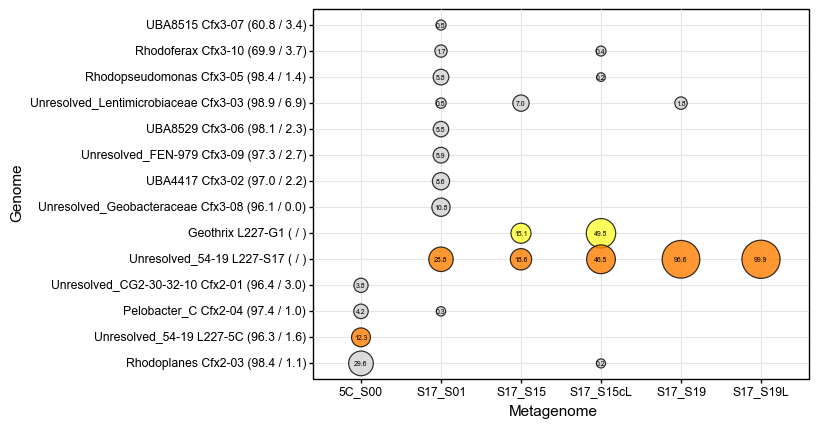

<ggplot: (8749770838532)>

In [12]:
# Make bubble plot
genome_plot = (ggplot(plot_data, aes(x='Sample-label', y='genome-label'))
               + geom_point(aes(size='relabund', fill='taxon_label'), alpha=0.8)
               + geom_text(aes(label='relabund-label'), size=5)
               + scale_fill_manual(values=['#ff7f00', '#ffff33', '#d2d2d2'])
               + scale_size_continuous(range=[3,15])
               + guides(fill=None, size=None)
               + theme_bw()
               + theme(text=element_text(family='Arial', colour='black'),
                      panel_border=element_rect(colour='black'))
               + xlab('Metagenome')
               + ylab('Genome')
               )

genome_plot

In [13]:
genome_plot.save(output_plot_filepath, width=90, height=100, units='mm')

/Analysis/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 90.00000000000001 x 100.0 mm image.
/Analysis/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/MAG_rel_abundances.pdf
